In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
import random
random.seed('IBP')

In [2]:
utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
utr_seq = utr_seq.loc[utr_seq.gene.notna()]
utr_seq

gene                                            utr_seq
4      VPS8  ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5      SSA1  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6      ERP2  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7     FUN14  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8      SPO7  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...
...     ...                                                ...
5625   TKL1  AATTCTGATCGTAGATCATCAGATTTGATATGATATTATTTGTGAA...
5626   MRL1  AACAATGCATACTTTGTACGTTCAAAATACAATGCAGTAGATATAT...
5627   GRS2  ACTGAAAAAAGAGGGGAATTTTTAGATACTGAAATGATATTTTAGA...
5629   MRI1  GATATCATTCTAATTAGACTCTCGAAATAATTACTTTTGTACTGTA...
5630   CUR1  AGAAATACGGGCTACGGAATTTACCGTGTGTCTTCAAATTGAGTGT...

[4870 rows x 2 columns]

In [3]:
genes_fi = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows = 6)
genes_fi = genes_fi.loc[:,['Standard Name', 'intensity']]
genes_fi.rename(columns = {'Standard Name':'gene'}, inplace = True)
genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
genes_fi = genes_fi.loc[genes_fi.intensity > 0]
# genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
fi_trans = [math.log(fi) for fi in genes_fi.intensity]
genes_fi.intensity = fi_trans
genes_fi = genes_fi.loc[genes_fi.intensity > -20]
genes_fi

C:\Users\dabaf\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


gene  intensity
0      SSA1   2.477076
1      ERP2  -1.204719
2     FUN14  -0.785451
3      SPO7  -3.608608
5      SWC3  -3.443864
...     ...        ...
5247   OPT2  -5.350277
5248    NaN  -4.446225
5250   SGE1  -6.448889
5252   ARR2  -4.412007
5253   ARR3  -6.448889

[4945 rows x 2 columns]

In [4]:
df = pd.merge(genes_fi, utr_seq, on = 'gene')
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

<AxesSubplot:>

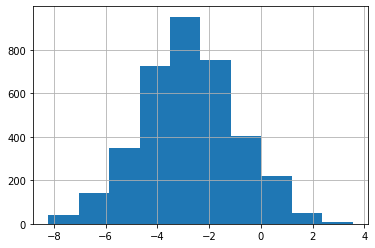

In [5]:
df.intensity.hist()

In [6]:
# Group genes by (log) intensity
class RangeDict(dict):
    def __getitem__(self, item):
        if not isinstance(item, range):
            for key in self:
                if item >= min(key) and item < max(key)+1:
                    return self[key]
            raise KeyError(item)
        else:
            return super().__getitem__(item)

int_dict = RangeDict({
    range(-10, -6) : 0,
    range(-6, -4) : 1,
    range(-4, -2) : 2,
    range(-2, 0) : 3,
    range(0, 4) : 4,
})

df['int_group'] = [int_dict[i] for i in df.intensity]


In [7]:
df.int_group.factorize()

(array([0, 1, 1, ..., 4, 3, 4], dtype=int64),
 Int64Index([4, 3, 2, 1, 0], dtype='int64'))

In [8]:
df

gene  intensity                                            utr_seq  \
0      SSA1   2.477076  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...   
1      ERP2  -1.204719  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...   
2     FUN14  -0.785451  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...   
3      SPO7  -3.608608  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...   
4      SWC3  -3.443864  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...   
...     ...        ...                                                ...   
3635   HPA2  -4.714288                AAAACACTAATTACCTCAGTAGTATGGATGTATAG   
3636   OPT2  -5.350277  ACTAGAACTTTTCTTAGAACGCTATCATTTCTTTATTTTTTTTTCT...   
3637   SGE1  -6.448889  AACAATTTTCCAACGTATAAATTAACTTATCGTAGTTCGATAAAAC...   
3638   ARR2  -4.412007  AGCTCCTCAAGCTTTATTGTTCCAGCATTAATGTAAAAGTCTTTTC...   
3639   ARR3  -6.448889  ATTGTTGACTCACCAAAAAATTACTTGGGCACCAATGAATAATACC...   

      int_group  
0             4  
1             3  
2             3  
3             2  
4             2  
...         ...  
3635          1  
3636          1  
3637          0  
3638          1  
3639          0  

[3640 rows x 4 columns]

### Sequence features extraction

In [9]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log(len(i)) for i in df.loc[:,'utr_seq']]

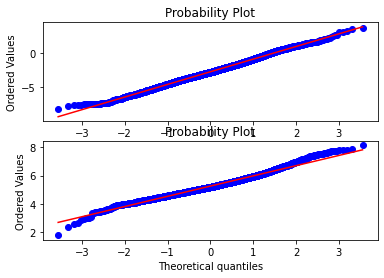

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [11]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [12]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [13]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

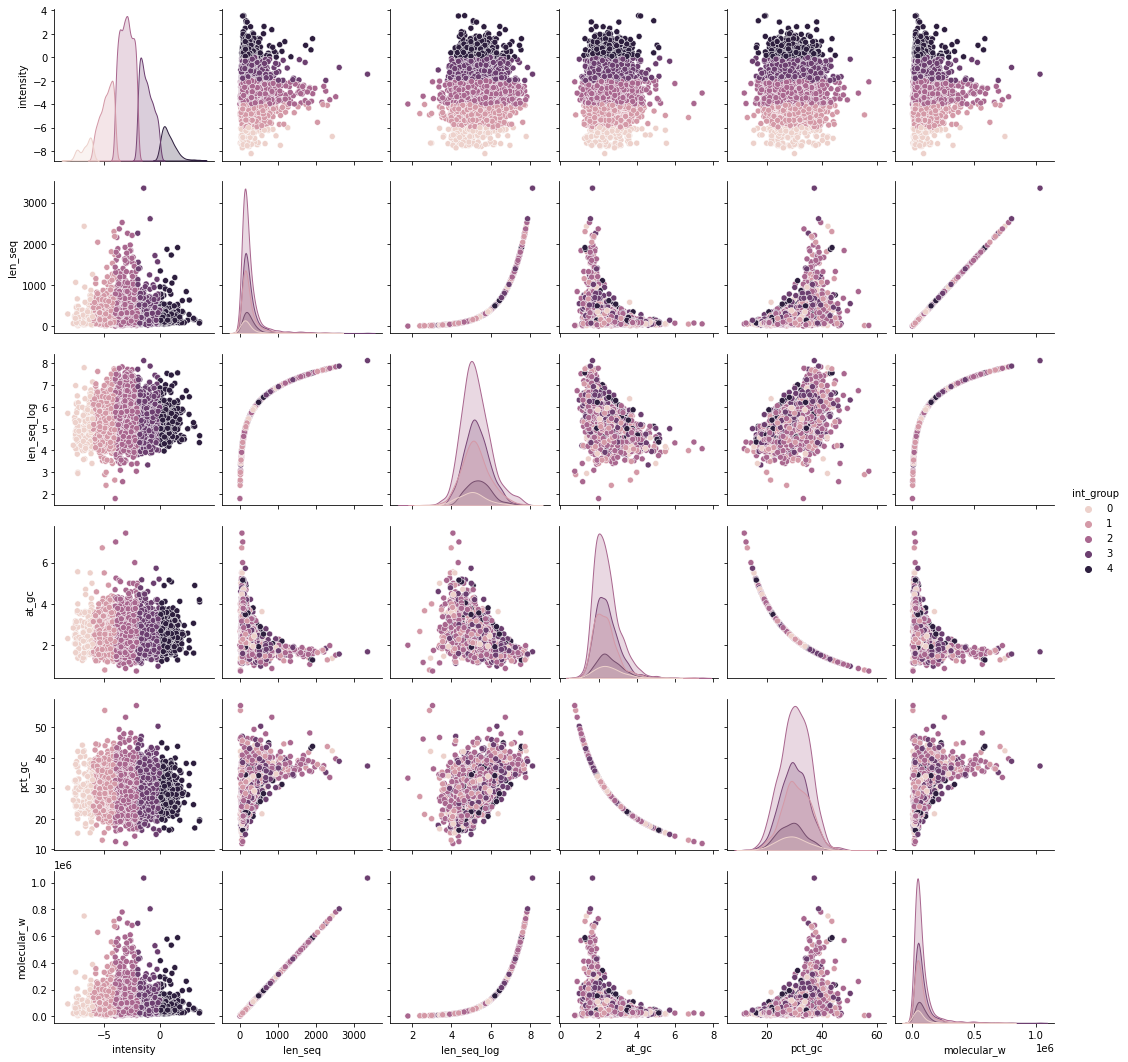

In [14]:
sns.pairplot(df, hue = 'int_group')

In [15]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Per group motif discovery (TBC)

Inspired by [this](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [16]:
seqs = [Seq(i) for i in df.loc[df.int_group == 0].utr_seq]

In [17]:
len(seqs)

161

In [18]:
K = 6
instances = []
for seq in seqs:
    for i in range(0, len(seq)-K):
        instances.append(seq[i:i+K])
len(instances)

35107

In [19]:
rnd_idx = [random.randint(0, len(instances)) for i in range(0, round(0.1*len(instances)))]
instances_sub = [instances[i] for i in rnd_idx]
len(instances_sub)

3511

In [20]:
motif = motifs.create(instances_sub)
print(motif.counts)

        0      1      2      3      4      5
A: 1152.00 1173.00 1176.00 1160.00 1168.00 1155.00
C: 553.00 568.00 576.00 630.00 587.00 592.00
G: 595.00 545.00 526.00 514.00 514.00 502.00
T: 1211.00 1225.00 1233.00 1207.00 1242.00 1262.00



In [21]:
weightMatrix = motif.pssm
print(weightMatrix)

        0      1      2      3      4      5
A:   0.39   0.42   0.42   0.40   0.41   0.40
C:  -0.67  -0.63  -0.61  -0.48  -0.58  -0.57
G:  -0.56  -0.69  -0.74  -0.77  -0.77  -0.81
T:   0.46   0.48   0.49   0.46   0.50   0.52



In [22]:
motif.degenerate_consensus

Seq('NNNNNN')

In [23]:
instances_new = []
max_scores = []
df_scores = df.copy()
for seq in seqs:
    max_score = 0
    max_pos = 0
    for position, score in weightMatrix.search(seq):
        if score > max_score:
            max_score = score
            max_pos = position
    if max_pos > 0 : instances_new.append(Seq(seq[max_pos:max_pos+K]))
    if max_pos < 0 : instances_new.append(Seq(seq[len(seq)+max_pos:len(seq)+max_pos+K]))
    max_scores.append(max_score)

In [24]:
motif = motifs.create(instances_new)
print(motif.counts)

        0      1      2      3      4      5
A:  79.00  86.00  52.00  86.00  64.00  72.00
C:   0.00   0.00   0.00   1.00   0.00   0.00
G:   0.00   0.00   1.00   0.00   0.00   0.00
T:  81.00  74.00 107.00  73.00  96.00  88.00



In [25]:
weightMatrix = motif.pssm
print(weightMatrix)

        0      1      2      3      4      5
A:   0.98   1.10   0.38   1.10   0.68   0.85
C:   -inf   -inf   -inf  -5.32   -inf   -inf
G:   -inf   -inf  -5.32   -inf   -inf   -inf
T:   1.02   0.89   1.42   0.87   1.26   1.14



In [26]:
motif.degenerate_consensus

Seq('WWTWWW')

In [27]:
motif.consensus

Seq('TATATT')

In [28]:
motif.anticonsensus

Seq('CCCGCC')

### Sequences from the paper

[Savinov, A., Brandsen, B. M., Angell, B. E., Cuperus, J. T., & Fields, S. (2021). Effects of sequence motifs in the yeast 3′ untranslated region determined from massively-parallel assays of random sequences. bioRxiv.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02509-6#Sec1)

In [29]:
# Efficiency element
eff_el1 = "TATATA"
eff_el2 = "TTTTTATA"
eff_ctrl = "GCGCGC"

In [30]:
# Mutational scan of efficiency element?

In [31]:
# Positioning element
pos_el = "AAWAAA"

In [32]:
# Puf protein binding sites
puf1_2 = "TAATNNNTAAT"
puf3 = "TGTANATA"
puf4 = "TGTANANTA"
puf5 = "TGTANNNNTA"
puf6 = "TTGT"

In [33]:
# Poly-T sequences
poly_t = "TTTTTTTT"

In [34]:
elements = [eff_el1, eff_el2, eff_ctrl,
           pos_el,
           puf1_2, puf3, puf4, puf5, puf6,
           poly_t]

In [35]:
for e in elements:
#     df[e] = [len(SeqUtils.nt_search(s,e)[1:]) for s in df.utr_seq]
    df[e] = [len(SeqUtils.nt_search(s,e)) > 1 for s in df.utr_seq]
#     df[e] = [len(e)*(len(SeqUtils.nt_search(s,e)[1:])/len(s)) for s in df.utr_seq]

In [36]:
df.head(5)

gene  intensity                                            utr_seq  \
0   SSA1   2.477076  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...   
1   ERP2  -1.204719  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...   
2  FUN14  -0.785451  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...   
3   SPO7  -3.608608  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...   
4   SWC3  -3.443864  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...   

   int_group  len_seq  len_seq_log     at_gc     pct_gc  molecular_w  TATATA  \
0          4      147     4.990433  2.585366  27.891156   45548.2183    True   
1          3      286     5.655992  2.445783  29.020979   88087.5535   False   
2          3      128     4.852030  2.459459  28.906250   39623.4302   False   
3          2      134     4.897840  2.268293  30.597015   41481.5762   False   
4          2      135     4.905275  2.375000  29.629630   41519.5406   False   

   TTTTTATA  GCGCGC  AAWAAA  TAATNNNTAAT  TGTANATA  TGTANANTA  TGTANNNNTA  \
0     False   False   False        False     False      False       False   
1     False   False    True        False     False      False        True   
2     False   False    True        False     False      False       False   
3     False   False   False        False     False      False       False   
4     False   False   False        False     False       True       False   

    TTGT  TTTTTTTT  
0  False     False  
1   True      True  
2  False     False  
3   True     False  
4   True     False

### Per group analysis

<AxesSubplot:xlabel='int_group'>

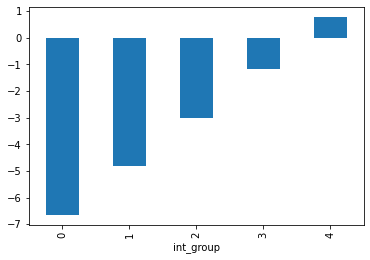

In [37]:
df.groupby('int_group')['intensity'].mean().plot.bar()

<AxesSubplot:xlabel='int_group'>

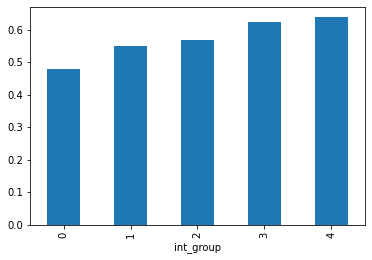

In [38]:
df.groupby('int_group')[eff_el1].mean().plot.bar()

In [39]:
# for e in elements:
#     pos = [[s, SeqUtils.nt_search(s,e)[1]] if len(SeqUtils.nt_search(s,e)) > 1 else np.nan for s in df.utr_seq]
#     df[e+'_pos'] = [np.nan if isinstance(p, float) else (len(p[0])+p[1])/len(p[0]) if p[1] < 0 else p[1]/len(p[0]) for p in pos]
#     df[e+'_pos'] = [0 if isinstance(p, float) else 1 for p in pos]

In [40]:
df

gene  intensity                                            utr_seq  \
0      SSA1   2.477076  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...   
1      ERP2  -1.204719  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...   
2     FUN14  -0.785451  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...   
3      SPO7  -3.608608  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...   
4      SWC3  -3.443864  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...   
...     ...        ...                                                ...   
3635   HPA2  -4.714288                AAAACACTAATTACCTCAGTAGTATGGATGTATAG   
3636   OPT2  -5.350277  ACTAGAACTTTTCTTAGAACGCTATCATTTCTTTATTTTTTTTTCT...   
3637   SGE1  -6.448889  AACAATTTTCCAACGTATAAATTAACTTATCGTAGTTCGATAAAAC...   
3638   ARR2  -4.412007  AGCTCCTCAAGCTTTATTGTTCCAGCATTAATGTAAAAGTCTTTTC...   
3639   ARR3  -6.448889  ATTGTTGACTCACCAAAAAATTACTTGGGCACCAATGAATAATACC...   

      int_group  len_seq  len_seq_log     at_gc     pct_gc  molecular_w  \
0             4      147     4.990433  2.585366  27.891156   45548.2183   
1             3      286     5.655992  2.445783  29.020979   88087.5535   
2             3      128     4.852030  2.459459  28.906250   39623.4302   
3             2      134     4.897840  2.268293  30.597015   41481.5762   
4             2      135     4.905275  2.375000  29.629630   41519.5406   
...         ...      ...          ...       ...        ...          ...   
3635          1       35     3.555348  2.181818  31.428571   10865.9827   
3636          1      162     5.087596  2.115385  32.098765   49521.6094   
3637          0      382     5.945421  2.441441  29.057592  118021.7822   
3638          1       79     4.369448  2.291667  30.379747   24256.5273   
3639          0      351     5.860786  1.949580  33.903134  108406.4657   

      TATATA  TTTTTATA  GCGCGC  AAWAAA  TAATNNNTAAT  TGTANATA  TGTANANTA  \
0       True     False   False   False        False     False      False   
1      False     False   False    True        False     False      False   
2      False     False   False    True        False     False      False   
3      False     False   False   False        False     False      False   
4      False     False   False   False        False     False       True   
...      ...       ...     ...     ...          ...       ...        ...   
3635   False     False   False   False        False     False      False   
3636   False     False   False   False        False     False      False   
3637    True     False   False   False        False     False      False   
3638   False     False   False   False        False     False      False   
3639   False     False   False    True        False     False      False   

      TGTANNNNTA   TTGT  TTTTTTTT  
0          False  False     False  
1           True   True      True  
2          False  False     False  
3          False   True     False  
4          False   True     False  
...          ...    ...       ...  
3635       False  False     False  
3636       False   True      True  
3637       False   True     False  
3638       False   True     False  
3639       False   True      True  

[3640 rows x 19 columns]

<AxesSubplot:xlabel='int_group'>

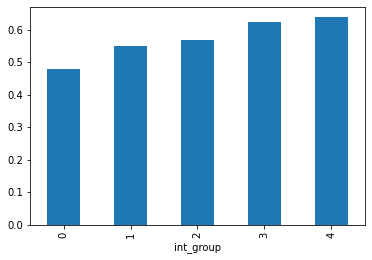

In [41]:
df.groupby('int_group', dropna = True)[eff_el1].mean().plot.bar()

In [42]:
grp0 = df.loc[df.int_group == 0][eff_el1]
grp1 = df.loc[df.int_group == 1][eff_el1]
grp2 = df.loc[df.int_group == 2][eff_el1]
grp3 = df.loc[df.int_group == 3][eff_el1]
grp4 = df.loc[df.int_group == 4][eff_el1]

In [43]:
grp012 = df.loc[df.int_group.isin(range(0,3))][eff_el1]
grp34 = df.loc[df.int_group.isin(range(4,6))][eff_el1]

In [44]:
f_val, p_val = stats.f_oneway(grp1, grp4)            
print ("One-way ANOVA P =", p_val )

One-way ANOVA P = 0.011027631343549817


In [45]:
f_val, p_val = stats.f_oneway(grp0, grp1, grp2, grp3, grp4)            
print ("One-way ANOVA P =", p_val )

One-way ANOVA P = 0.00031879488431705454


In [46]:
df

gene  intensity                                            utr_seq  \
0      SSA1   2.477076  AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...   
1      ERP2  -1.204719  AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...   
2     FUN14  -0.785451  AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...   
3      SPO7  -3.608608  AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...   
4      SWC3  -3.443864  AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...   
...     ...        ...                                                ...   
3635   HPA2  -4.714288                AAAACACTAATTACCTCAGTAGTATGGATGTATAG   
3636   OPT2  -5.350277  ACTAGAACTTTTCTTAGAACGCTATCATTTCTTTATTTTTTTTTCT...   
3637   SGE1  -6.448889  AACAATTTTCCAACGTATAAATTAACTTATCGTAGTTCGATAAAAC...   
3638   ARR2  -4.412007  AGCTCCTCAAGCTTTATTGTTCCAGCATTAATGTAAAAGTCTTTTC...   
3639   ARR3  -6.448889  ATTGTTGACTCACCAAAAAATTACTTGGGCACCAATGAATAATACC...   

      int_group  len_seq  len_seq_log     at_gc     pct_gc  molecular_w  \
0             4      147     4.990433  2.585366  27.891156   45548.2183   
1             3      286     5.655992  2.445783  29.020979   88087.5535   
2             3      128     4.852030  2.459459  28.906250   39623.4302   
3             2      134     4.897840  2.268293  30.597015   41481.5762   
4             2      135     4.905275  2.375000  29.629630   41519.5406   
...         ...      ...          ...       ...        ...          ...   
3635          1       35     3.555348  2.181818  31.428571   10865.9827   
3636          1      162     5.087596  2.115385  32.098765   49521.6094   
3637          0      382     5.945421  2.441441  29.057592  118021.7822   
3638          1       79     4.369448  2.291667  30.379747   24256.5273   
3639          0      351     5.860786  1.949580  33.903134  108406.4657   

      TATATA  TTTTTATA  GCGCGC  AAWAAA  TAATNNNTAAT  TGTANATA  TGTANANTA  \
0       True     False   False   False        False     False      False   
1      False     False   False    True        False     False      False   
2      False     False   False    True        False     False      False   
3      False     False   False   False        False     False      False   
4      False     False   False   False        False     False       True   
...      ...       ...     ...     ...          ...       ...        ...   
3635   False     False   False   False        False     False      False   
3636   False     False   False   False        False     False      False   
3637    True     False   False   False        False     False      False   
3638   False     False   False   False        False     False      False   
3639   False     False   False    True        False     False      False   

      TGTANNNNTA   TTGT  TTTTTTTT  
0          False  False     False  
1           True   True      True  
2          False  False     False  
3          False   True     False  
4          False   True     False  
...          ...    ...       ...  
3635       False  False     False  
3636       False   True      True  
3637       False   True     False  
3638       False   True     False  
3639       False   True      True  

[3640 rows x 19 columns]

### PCA

In [47]:
from sklearn.decomposition import PCA
import plotly.express as px

In [48]:
features = [*elements, 'len_seq_log', 'at_gc', 'pct_gc']
df_temp = df.loc[:, features]

In [49]:
pca = PCA(n_components = 4)
components = pca.fit_transform(df_temp)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [50]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df.intensity)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [51]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Classification (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [52]:
df['int_bool'] = [i > 2 for i in df.int_group]

In [53]:
print(features)

['TATATA', 'TTTTTATA', 'GCGCGC', 'AAWAAA', 'TAATNNNTAAT', 'TGTANATA', 'TGTANANTA', 'TGTANNNNTA', 'TTGT', 'TTTTTTTT', 'len_seq_log', 'at_gc', 'pct_gc']


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, features], df.int_bool, test_size=0.5,
                                                    stratify=df.int_bool, random_state=123456)

In [55]:
X_train

TATATA  TTTTTATA  GCGCGC  AAWAAA  TAATNNNTAAT  TGTANATA  TGTANANTA  \
2897    True     False   False    True        False     False      False   
790     True     False   False    True        False     False      False   
1906   False     False   False   False        False     False      False   
2682    True     False    True    True        False     False      False   
2359    True     False   False   False        False     False      False   
...      ...       ...     ...     ...          ...       ...        ...   
25      True     False   False   False        False     False      False   
3165   False     False   False    True        False      True       True   
118    False     False   False   False        False     False      False   
3443    True     False   False   False        False     False      False   
1341    True     False   False    True        False     False      False   

      TGTANNNNTA   TTGT  TTTTTTTT  len_seq_log     at_gc     pct_gc  
2897       False   True     False     5.476464  2.793651  26.359833  
790         True   True     False     5.855072  2.597938  27.793696  
1906       False   True      True     5.164786  1.692308  37.142857  
2682       False   True     False     5.883322  1.895161  34.540390  
2359       False  False     False     5.713733  1.634783  37.953795  
...          ...    ...       ...          ...       ...        ...  
25         False  False     False     5.283204  1.558442  39.086294  
3165       False   True     False     5.231109  2.528302  28.342246  
118         True   True     False     5.214936  2.538462  28.260870  
3443       False  False     False     4.094345  4.454545  18.333333  
1341       False   True     False     5.891644  2.067797  32.596685  

[1820 rows x 13 columns]

In [56]:
y_train

2897    False
790      True
1906    False
2682    False
2359     True
        ...  
25      False
3165     True
118     False
3443    False
1341    False
Name: int_bool, Length: 1820, dtype: bool

In [57]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

C:\Users\dabaf\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(oob_score=True, random_state=123456)

In [58]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.636
Mean accuracy score: 0.639


<AxesSubplot:>

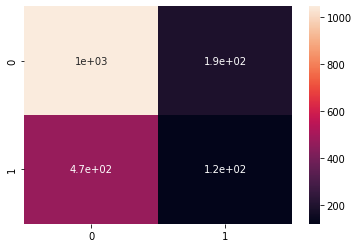

In [59]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

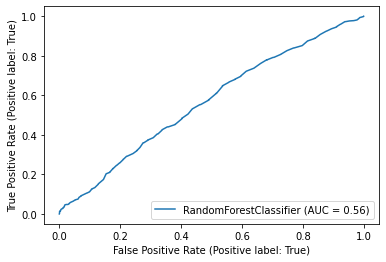

In [60]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [61]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, features], df.intensity, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [62]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

C:\Users\dabaf\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)

In [63]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: -0.0798
Test data R-2 score: -0.0548
Test data Spearman correlation: 0.137
Test data Pearson correlation: 0.122


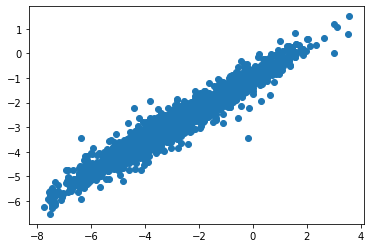

In [64]:
plt.scatter(y_train, predicted_train)

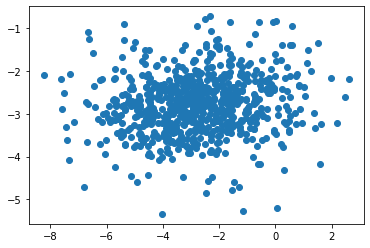

In [65]:
plt.scatter(y_test, predicted_test)